In [1]:
%load_ext autoreload
%autoreload 2
from confignb import *

X, y, ks, pts, masks = util.load_data("data/raw/ASCADv.h5")
print(f"NaN present in X: {np.isnan(X).any().any()}")

NaN present in X: False


Dataset zawiera 300 000 próbek (200 000 w zbiorze treningowym + 100 000 w zbiorze testowym). Użyta przeze mnie wersja to wycięte *okno zainteresowania* (tzw. *ślad* o długości 1400 próbek), w którym procesor wykonuje operację [S-box](../SBOX.md). Zbiór ten jest powszechnie stosowany jako benchmark dla modeli uczenia głębokiego, jednak celem mojego projektu jest weryfikacja wyników osiągalnych przy użyciu klasycznego uczenia maszynowego.

Każda próbka w śladzie reprezentuje amplitudę pola elektromagnetycznego zmierzoną oscyloskopem w konkretnym cyklu zegara procesora (wartości znormalizowane w zakresie od -128 do 127). Tak wyglądają próbki dla klas 0x00 i 0xFF:

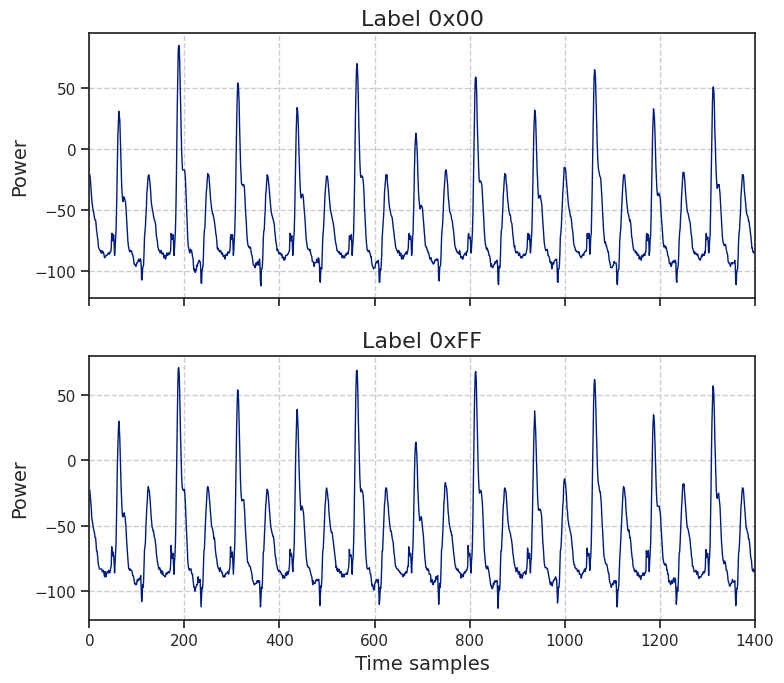

In [2]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), sharex=True)

trace_0x00 = util.sample_trace(X, y, byte_val=0x00, seed=SEED)
plots.labs(sns.lineplot(trace_0x00, linewidth=1, ax=ax1),
    xlab="Time samples", ylab="Power", title="Label 0x00")
ax1.set_xlim(0, len(trace_0x00))
ax1.grid(True, linestyle='--')

trace_0xFF = util.sample_trace(X, y, byte_val=0xFF, seed=SEED)
plots.labs(sns.lineplot(trace_0xFF, linewidth=1, ax=ax2),
       xlab="Time samples", ylab="Power", title="Label 0xFF")
ax2.set_xlim(0, len(trace_0xFF))
ax2.grid(True, linestyle='--')

fig.tight_layout(h_pad=1.5)
plots.savetight(fig, '00_sample_traces')

Każdy "pik" reprezentuje skok poboru mocy podczas ładowania danych do rejestru (ładnie widać poszczególne cykle procesora). Wg. opisu datasetu dane sa zsynchronizowane, więc każdy punkt w czasie można traktować również jako cechę, co w tym przypadku sprowadza zadanie do zwykłej klasyfikacji. 

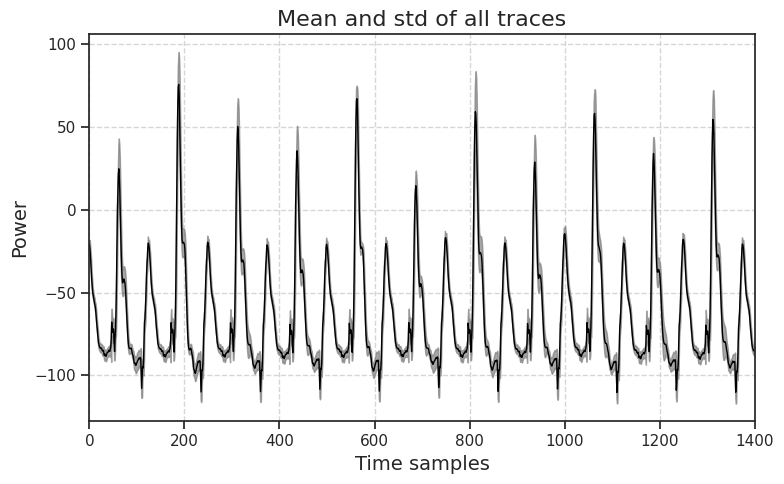

: 

In [ ]:
fig, ax = plots.plot_mean_std(X)
plots.labs(ax,
    xlab="Time samples", ylab="Power",
    title="Mean and std of all traces")

fig.tight_layout()
plots.savetight(fig, '00_mean_std_trace')

Widać, że punkty w podobnych momentach cyklu są silnie skorelowane:

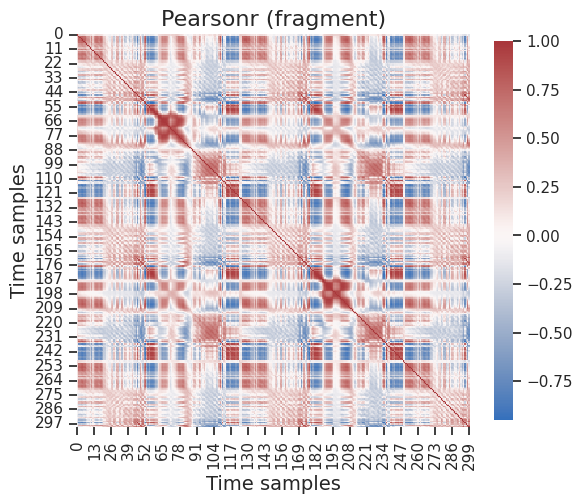

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(np.corrcoef(X, rowvar=False)[:300, :300], cmap="vlag", center=0,
            square=True, ax=ax, cbar_kws={'shrink': 0.7})

plots.labs(ax, xlab="Time samples", ylab="Time samples",
       title="Pearsonr (fragment)")

fig.tight_layout()
plots.savetight(fig, "00_pearsonr_time_samples")

/tmp/ipykernel_288529/2067140876.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


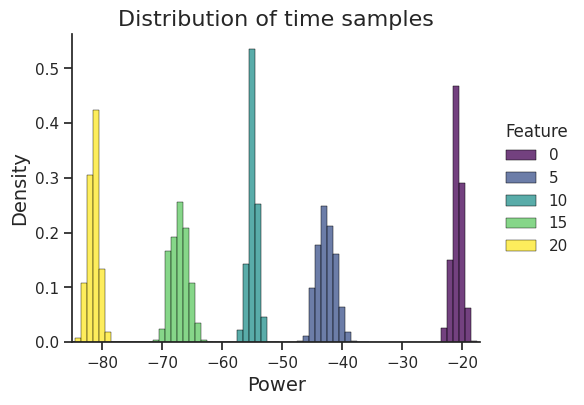

In [8]:
idx = [0, 5, 10, 15, 20]

fig = plt.figure(figsize=(6, 4))
gs = plots.gridspec.GridSpec(1, 2, width_ratios=[9, 1], wspace=0.05, figure=fig)

ax = fig.add_subplot(gs[0, 0])
cm = sns.color_palette("viridis", len(idx), as_cmap=True)
norm = plt.Normalize(vmin=0, vmax=max(idx))

for i in idx:
    sns.histplot(
        X[:, i],
        edgecolor="black",
        discrete=True,
        color=cm(norm(i)),
        stat="density",
        ax=ax,
    )

lo, hi = np.percentile(X[:, idx], [1e-3, 100 - 1e-3])
ax.set_xlim(lo, hi)

plots.labs(ax,
    xlab="Power", ylab="Density",
    title="Distribution of time samples")

ax_legend = fig.add_subplot(gs[0, 1])
ax_legend.axis("off")

old_legend = ax.legend([f"{i}" for i in idx], title="Feature")
handles = old_legend.legend_handles
labels = [t.get_text() for t in old_legend.get_texts()]
title = old_legend.get_title().get_text()

ax_legend.legend(handles, labels, title=title, loc="center left", frameon=False)
old_legend.remove()

sns.despine(ax=ax)
fig.tight_layout()
plots.savetight(fig, "00_dist_time_samples")

Niestety, ciężko wykonać jakikolwiek test normalności dla tak dużej liczby obserwacji, tym bardziej że dane są skwantyzowane. Sprawdzę, jak wygląda rozkład skosu i kurtozy, i czy są wystarczające żeby uznać rozkład w przybliżeniu za normalny.

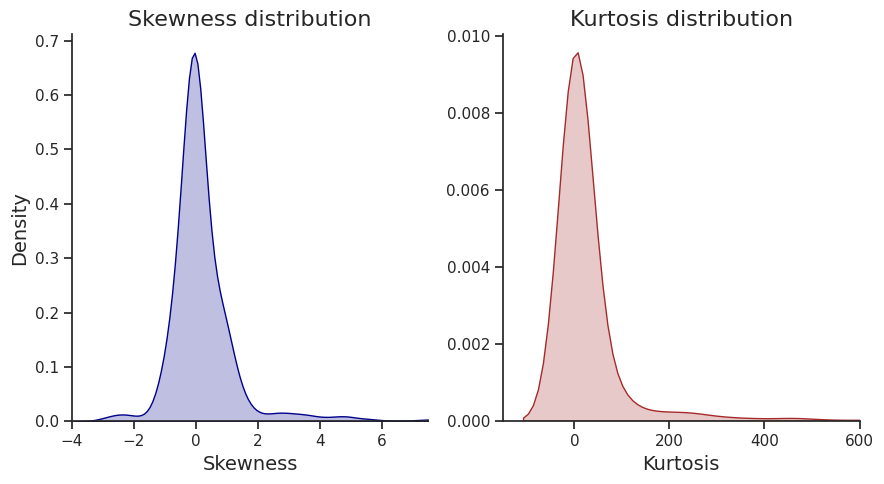

In [9]:
from scipy import stats

sk = stats.skew(X, axis=0, bias=False)
kt = stats.kurtosis(X, axis=0, fisher=True, bias=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
sns.kdeplot(sk, ax=ax1, fill="darkblue", color="darkblue")
plots.labs(ax1, "Skewness", "Density", "Skewness distribution")
ax1.set_xlim(-4, 7.5)

sns.kdeplot(kt, ax=ax2, fill="brown", color="brown")
plots.labs(ax2, "Kurtosis", title="Kurtosis distribution")
ax2.set_xlim(-150, 600)

sns.despine(fig)
plt.tight_layout()
plots.savetight(fig, "00_skewness_kurtosis")

Jak oczekiwałem, skośność i kurtoza gromadzą się wokół zera.

In [10]:
from scipy.stats import f_oneway

f_stats, p_values = f_oneway(*(X[y == lv] for lv in np.unique(y)))
print(np.sum(p_values < 0.001))

0


In [11]:
from scipy.stats import spearmanr

corrs = [spearmanr(X[:, i], y)[0] for i in trange(X.shape[1])]
print(np.sum(np.abs(np.array(corrs)) > 0.01))

  0%|          | 0/1400 [00:00<?, ?it/s]

0


In [13]:
from scipy.stats import pearsonr

corrs = [pearsonr(X[:, i], util.hw(y))[0] for i in trange(X.shape[1])]
print(np.sum(np.abs(np.array(corrs)) > 0.01))

  0%|          | 0/1400 [00:00<?, ?it/s]

0


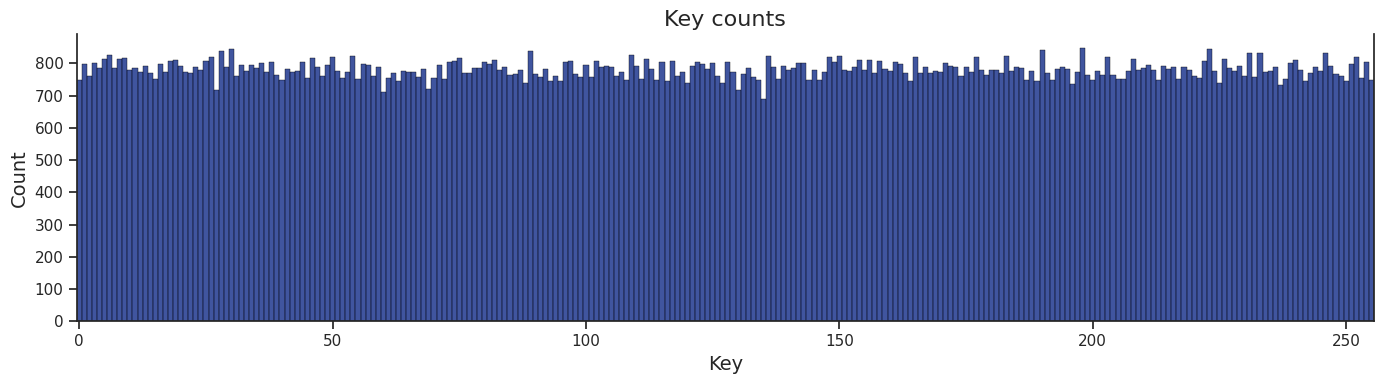

In [14]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.histplot(ks, discrete=True, edgecolor="black", ax=ax)
plots.labs(ax, "Key", "Count", "Key counts")
ax.set_xlim(-0.5, 255.5)
sns.despine(ax=ax, right=False)
fig.tight_layout()
plots.savetight(fig, "00_key_counts")

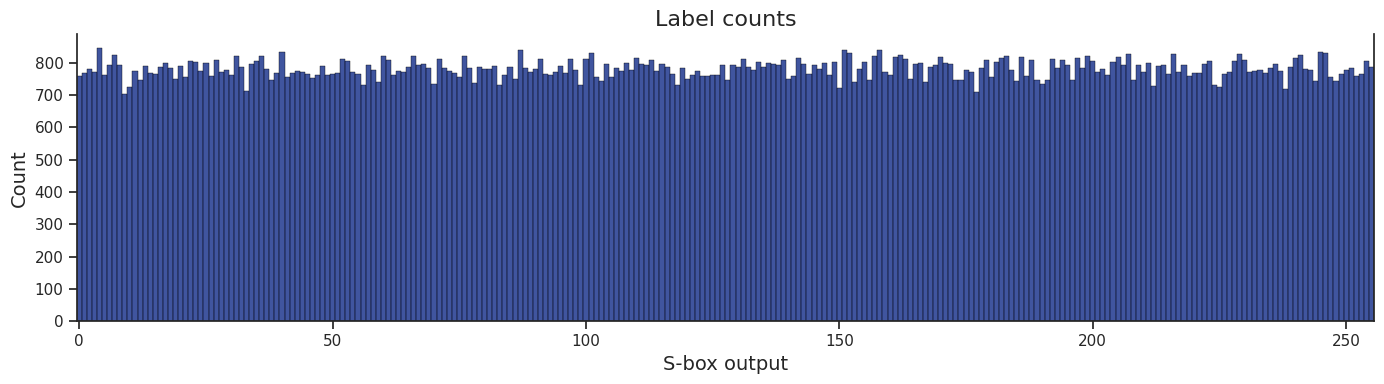

In [15]:
fig, ax = plt.subplots(figsize=(14, 4))
sns.histplot(y, discrete=True, edgecolor="black", ax=ax)
plots.labs(ax, "S-box output", "Count", "Label counts")
ax.set_xlim(-0.5, 255.5)
sns.despine(ax=ax, right=False)
fig.tight_layout()
plots.savetight(fig, "00_label_counts")